<a href="https://colab.research.google.com/github/michsiec/fmnist-image-classification/blob/main/fmnist_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Neural Network using TensorFlow for Fashion-MNIST dataset clothes recognition

[Fashion-MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist) contains 70,000 images in 10 categories. Each image is of size 28x28.

In the following notebook, few models has been built, trained, and evaluated in order to achieve satisfying metrics.



In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Install TensorBoard
%pip install -q -U tensorboard-plugin-profile 

In [ ]:
# This function generates the path of the log subdirectory based on the current date and time so that it's different at each run
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir = "my_logs"):
  return Path(root_logdir) / strftime("run%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir() # e.g., my_logs/run_2022_12_05_16_21_37

### Loading and splitting the data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [ ]:
# Shape and data type of the training set
X_train.shape, X_train.dtype

((55000, 28, 28), dtype('uint8'))

In [ ]:
# Shape and data type of the testing set
X_test.shape, X_test.dtype

((10000, 28, 28), dtype('uint8'))

### Data Visualization

Label: 9

Image pixel array:
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  82 187  26   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   1   0   0 179 240 237 255 240 139  83  64  43  60  54   0   1]
 [  0   0   0   0   0   0   0   0   0   1   0   0   1   0  58 239 222 234 238 246 252 254 255 248 255 187   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2   3 

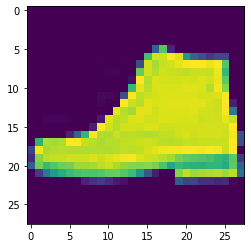

In [ ]:
index = 42

# Set number of characters per row when printing
np.set_printoptions(linewidth = 320)

# Print the label and image
print(f"Label: {y_train[index]}")
print(f"\nImage pixel array:\n {X_train[index]}")

# Visualize the image
plt.imshow(X_train[index])

In [ ]:
# Scale the pixel intensities down to the 0-1 range by dividing them by 255.0 (also converts them to floats)
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

In [ ]:
print(f"Maximum value after pixel normalization: {np.max(X_train)}")
print(f"Shape of the training set after reshaping: {X_train.shape}")
print(f"Shape of one image after reshaping: {X_train[0].shape}")

Maximum value after pixel normalization: 1.0
Shape of the training set after reshaping: (55000, 28, 28)
Shape of one image after reshaping: (28, 28)


In [ ]:
# List of class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# First image in the training set
class_names[y_train[0]]

'Ankle boot'

### Defining callbacks for model training

In [ ]:
# Define a custom callback that stops training when accuracy is bigger than 95%  
class AccStopCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("accuracy") is not None and logs.get("accuracy")) >= 0.95:
        print("Accuracy reached 99.5%, so stopping training!")
        self.model.stop_training = True

acc_limit_cb = AccStopCallback()


# Custom callback that displays the ratio between the validation loss and the training loss during training to detect overfitting
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    ratio = logs["val_loss"] / logs["loss"]
    print(f" Epoch = {epoch}, val/train = {ratio:.2f}")

val_train_ratio_cb = PrintValTrainRatioCallback() 


# Early Stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True)


# TensorBoard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir, profile_batch = (100, 200))

### 1. Simple NN Model

In [ ]:
# Building simple NN model using Sequential API

tf.random.set_seed(42) # for results reproducibility

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = [28,28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation = "relu"),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

# Compile the model
model1.compile(loss = "sparse_categorical_crossentropy",
               optimizer = tf.keras.optimizers.RMSprop(),
               metrics = ["accuracy"])

In [ ]:
# Summary of the model
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 dense_93 (Dense)            (None, 300)               235500    
                                                                 
 dense_94 (Dense)            (None, 100)               30100     
                                                                 
 dense_95 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


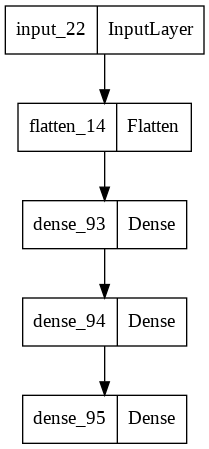

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model1)

### Model Training & Evaluation

In [ ]:
# Fit the model
history = model1.fit(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid), callbacks = [tensorboard_cb, val_train_ratio_cb, early_stopping_cb])

# Evaluate the model on test data
# model1.evaluate(X_test, y_test)

Epoch 1/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1651 - accuracy: 0.9581 - val_loss: 2.6938 - val_accuracy: 0.8826
Epoch 2/100
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1567 - accuracy: 0.9580 - val_loss: 2.8000 - val_accuracy: 0.8868
Epoch 3/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1659 - accuracy: 0.9581 - val_loss: 2.9666 - val_accuracy: 0.8782
Epoch 4/100
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1489 - accuracy: 0.9596 - val_loss: 2.7623 - val_accuracy: 0.8862
Epoch 5/100
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1578 - accuracy: 0.9580 - val_loss: 2.7689 - val_accuracy: 0.8754
Epoch 6/100
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1607 - accuracy: 0.9584 - val_loss: 2.7641 - val_accuracy: 0.8820
Epoch 7/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1650 - accuracy: 0.9593 - val_loss: 2.7536 -

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 1719}

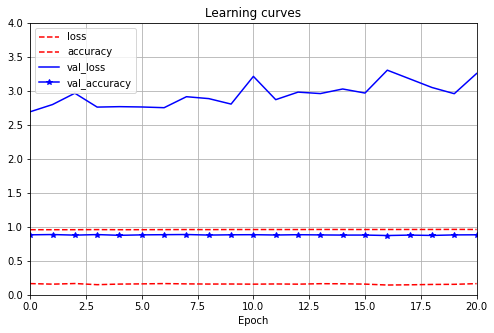

In [ ]:
pd.DataFrame(history.history).plot(
    figsize = (8, 5), xlim = [0, 20], ylim = [0, 4], grid = True,
    xlabel = "Epoch", style = ['r--', 'r--', 'b-', 'b-*'])
plt.title("Learning curves")
plt.show()

Looks like the first model has overfitted the training data.

In [ ]:
# Save the model
model1.save("model_1", save_format = "tf")

### 2. Simple Convolutional Model

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Create a model
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = "relu", input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

# Compile the model
model2.compile(loss = "sparse_categorical_crossentropy",
               optimizer = "adam",
               metrics = ["accuracy"])

In [ ]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 3, 3, 32)          9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 1, 1, 32)       

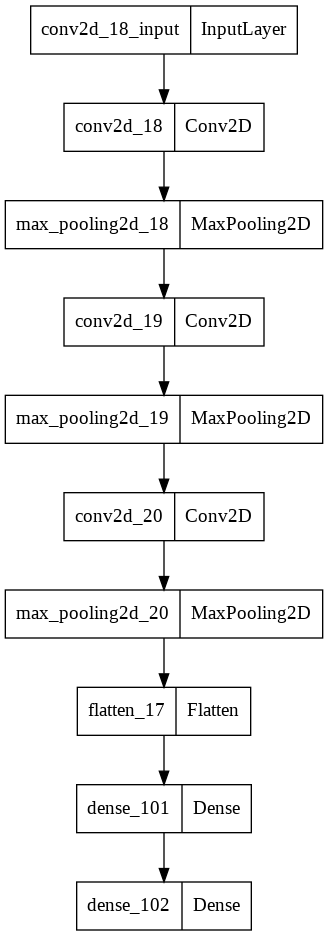

In [ ]:
tf.keras.utils.plot_model(model2)

In [ ]:
# Train the model
history = model2.fit(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid), callbacks = [tensorboard_cb, val_train_ratio_cb, early_stopping_cb])

# Evaluate the model on the test data
# model.evaluate(X_test, y_test)

Epoch 1/100
1719/1719 [==============================] - 42s 24ms/step - loss: 0.5278 - accuracy: 0.8071 - val_loss: 0.4702 - val_accuracy: 0.8318
Epoch 2/100
1719/1719 [==============================] - 40s 24ms/step - loss: 0.4394 - accuracy: 0.8383 - val_loss: 0.4432 - val_accuracy: 0.8356
Epoch 3/100
1719/1719 [==============================] - 40s 23ms/step - loss: 0.3948 - accuracy: 0.8551 - val_loss: 0.4063 - val_accuracy: 0.8538
Epoch 4/100
1719/1719 [==============================] - 44s 26ms/step - loss: 0.3640 - accuracy: 0.8669 - val_loss: 0.3701 - val_accuracy: 0.8592
Epoch 5/100
1719/1719 [==============================] - 41s 24ms/step - loss: 0.3391 - accuracy: 0.8752 - val_loss: 0.3382 - val_accuracy: 0.8762
Epoch 6/100
1719/1719 [==============================] - 42s 24ms/step - loss: 0.3213 - accuracy: 0.8805 - val_loss: 0.3522 - val_accuracy: 0.8742
Epoch 7/100
1719/1719 [==============================] - 40s 23ms/step - loss: 0.3019 - accuracy: 0.8887 - val_loss: 0

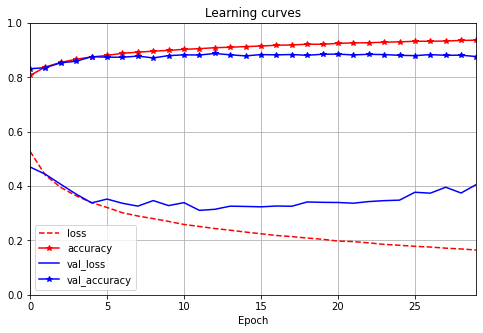

In [ ]:
pd.DataFrame(history.history).plot(
    figsize = (8, 5), xlim = [0, 29], ylim = [0, 1], grid = True, 
    xlabel = "Epoch", style = ['r--', 'r-*', 'b-', 'b-*'])

plt.title("Learning curves")
plt.show()

In [ ]:
# Save the model
model2.save("model_2", save_format = "tf")

### 3. Simple NN Model with Batch Normalization

In [182]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation = "relu",
                          kernel_initializer = "he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation = "relu",
                          kernel_initializer = "he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model3.compile(loss = "sparse_categorical_crossentropy",
               optimizer = "adam",
               metrics = ['accuracy'])

In [183]:
model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_103 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_104 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)            

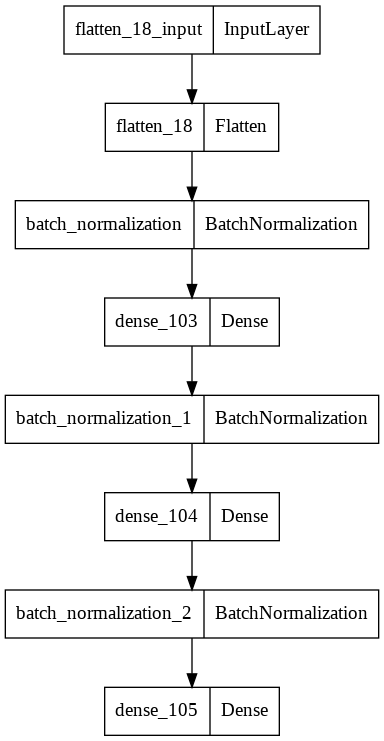

In [184]:
tf.keras.utils.plot_model(model3)

In [185]:
# Train the model
history = model3.fit(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid), callbacks = [tensorboard_cb, val_train_ratio_cb, early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 19s 10ms/step - loss: 0.4725 - accuracy: 0.8309 - val_loss: 0.3490 - val_accuracy: 0.8662
Epoch 2/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.3638 - accuracy: 0.8665 - val_loss: 0.3599 - val_accuracy: 0.8646
Epoch 3/100
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3300 - accuracy: 0.8785 - val_loss: 0.3394 - val_accuracy: 0.8768
Epoch 4/100
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3021 - accuracy: 0.8885 - val_loss: 0.3083 - val_accuracy: 0.8814
Epoch 5/100
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2818 - accuracy: 0.8953 - val_loss: 0.3120 - val_accuracy: 0.8854
Epoch 6/100
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2647 - accuracy: 0.9009 - val_loss: 0.3419 - val_accuracy: 0.8806
Epoch 7/100
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2502 - accuracy: 0.9057 - val_loss: 0.315

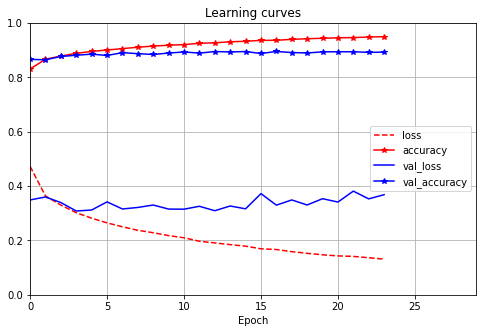

In [186]:
pd.DataFrame(history.history).plot(
    figsize = (8, 5), xlim = [0, 29], ylim = [0, 1], grid = True, 
    xlabel = "Epoch", style = ['r--', 'r-*', 'b-', 'b-*'])

plt.title("Learning curves")
plt.show()

In [187]:
model3.save("model_3", save_format = "tf")

### Next steps:
* built a couple more models for better comparison
* hyperparameter tuning
* introducing TensorBoard for better visualisations
* evaluation using more metrics